In [4]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import quaternion
from scipy.spatial.transform import Rotation

1. Make a spiral trajectory in 3D.
2. Calculate position, velocity, and acceleration along the spiral.
3. Define orientation changes along the paths.
4. Generate synthetic accelerometer and gyroscope readings.
5. Add realistic noise to make IMU readings more realistic.

$$\omega=\frac{v}{r}$$

$$\begin{cases}
x=R\cos(\omega)\\
y=R\sin(\omega)\\
z=H\frac{t}{t_0}
\end{cases}$$

In [5]:
def make_spiral(t: int, radius: float, height: float, loops: int) -> np.ndarray:
    """
    :param t: number of samples
    :param radius: radius of the spiral
    :param height: height of the spiral
    :param loops: number of loops in the spiral
    :return: numpy array shaped (3,t)
    """
    omega = 2 * np.pi * loops / t[-1]
    
    x = radius * np.cos(omega*t)
    y = radius * np.sin(omega*t)
    z = height * t/t[-1]
    
    vx = - radius * omega * np.sin(omega*t)
    vy = radius * omega * np.cos(omega*t)
    vz = height / t[-1]
    
    ax = - radius * omega ** 2 * np.sin(omega*t)
    ay = - radius * omega ** 2 * np.cos(omega*t)
    az = 0
    
    spiral_data = np.array([
        [x,y,z],
        [vx,vy,vz],
        [ax,ay,az]
    ])
    
    return spiral_data
    
def make_spiral_quaternions(duration:int, sample_rate:float, radius:float, height:float, loop:int) -> dict:
    """
    
    :param duration: duration of the measurement taking process
    :param sample_rate: rate at which we want to capture sample points
    :param radius: radius of the spiral
    :param height: height of spiral
    :param loop: number of revolutions of the spiral
    :return: 
    """
    t = np.linspace(0, duration, int(duration * sample_rate))
    
    omega = 2 * np.pi * loop / duration
    
    x = radius * np.cos(omega * t)
    y = radius * np.sin(omega * t)
    z = height * t / duration
    
    dx = -radius * omega * np.sin(omega * t)
    dy = radius * omega * np.cos(omega * t)
    dz = height / duration * np.ones_like(t)
    
    tangent = np.column_stack([dx, dy, dz])
    tangent = tangent / np.linalg.norm(tangent, axis=1)[:, np.newaxis]
    
    up = np.tile([0, 0, 1], (len(t), 1))
    
    right = np.cross(tangent, up)
    right = right / np.linalg.norm(right, axis=1)[:, np.newaxis]
    
    up = np.cross(right, tangent)
    
    rotation_matrices = np.zeros((len(t), 3, 3))
    for i in range(len(t)):
        rotation_matrices[i] = np.column_stack([right[i], up[i], tangent[i]])
    
    r = Rotation.from_matrix(rotation_matrices)
    quaternions = r.as_quat()  # Returns (x, y, z, w)
    
    quaternions = np.column_stack([quaternions[:, 3], quaternions[:, 0], quaternions[:, 1], quaternions[:, 2]])
    
    noise_std = 0.001  # Adjust noise level as needed
    noisy_quaternions = quaternions + np.random.normal(0, noise_std, quaternions.shape)
    
    noisy_quaternions = noisy_quaternions / np.linalg.norm(noisy_quaternions, axis=1)[:, np.newaxis]
    
    return {
        'time': t,
        'position': np.column_stack([x, y, z]),
        'quaternions': noisy_quaternions,
        'clean_quaternions': quaternions
    }
        

In [6]:
def add_noise(data: np.ndarray, noise_std: float) -> np.ndarray:
    """
    
    :param data: the data on which we are adding noise
    :param noise_std: standard deviation of the noise
    :return: 
    """
    return data + np.random.normal(scale=noise_std, size=data.shape)

In [7]:
def plot_trajectory_and_orientations(data: np.array, sample_points: int):
    """
    
    :param data: data we'll be plotting
    :param sample_points: 
    :return: 
    """
    fig = plt.figure(figsize=(12, 5))
    
    # Trajectory plot
    ax1 = fig.add_subplot(121, projection='3d')
    ax1.plot(data['position'][:, 0], data['position'][:, 1], data['position'][:, 2])
    
    # Sample points for visualization
    indices = np.linspace(0, len(data['time'])-1, sample_points, dtype=int)
    
    # Convert quaternions back to rotation matrices for visualization
    r = Rotation.from_quat(np.column_stack([data['quaternions'][:, 1:], data['quaternions'][:, 0]]))
    rotation_matrices = r.as_matrix()
    
    # Plot coordinate frames at sample points
    length = 0.2
    for idx in indices:
        pos = data['position'][idx]
        rot_mat = rotation_matrices[idx]
        
        # Plot coordinate axes
        for axis, color in enumerate(['r', 'g', 'b']):
            direction = rot_mat[:, axis]
            ax1.quiver(pos[0], pos[1], pos[2],
                      direction[0], direction[1], direction[2],
                      length=length, color=color)
    
    ax1.set_title('Trajectory with Orientation Frames')
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')
    ax1.set_zlabel('Z')
    
    # Quaternion components plot
    ax2 = fig.add_subplot(122)
    ax2.plot(data['time'], data['quaternions'][:, 0], label='w')
    ax2.plot(data['time'], data['quaternions'][:, 1], label='x')
    ax2.plot(data['time'], data['quaternions'][:, 2], label='y')
    ax2.plot(data['time'], data['quaternions'][:, 3], label='z')
    ax2.set_title('Quaternion Components')
    ax2.set_xlabel('Time [s]')
    ax2.set_ylabel('Value')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()


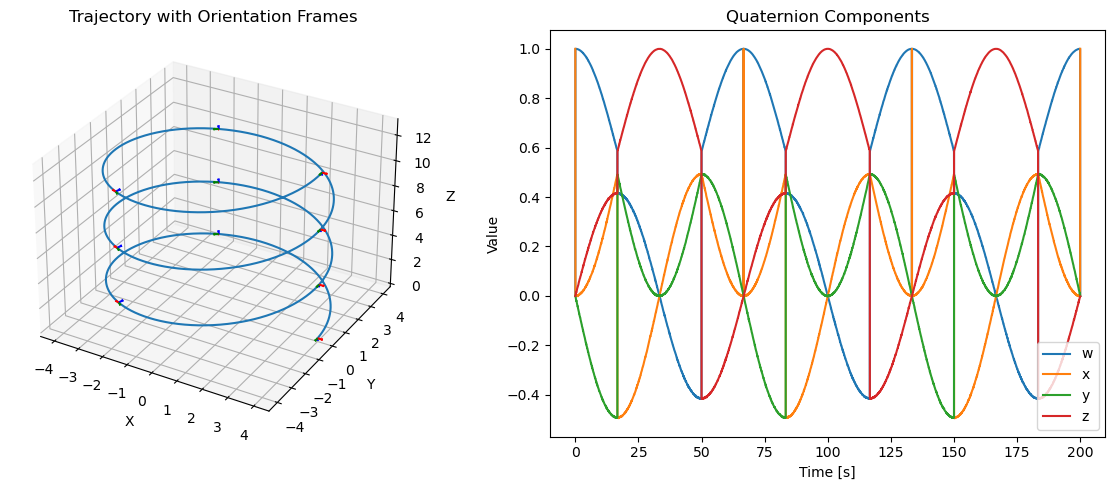

In [10]:
quaternions = make_spiral_quaternions(200, 20, 4, 13, 3)
#quaternions_with_noise = add_noise(quaternions, noise_std=0.1)

plot_trajectory_and_orientations(quaternions, 10)